In [145]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats


In [125]:
data = pd.read_csv('ab_data_tourist.zip')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


Наша таблица представлена следующими полями:

* user_id — идентификатор пользователя, зашедшего на сайт;
* data — дата посещения сайта;
* group — группа теста (контрольная — А или тестовая — B);
* purchase — признак покупки: совершил ли пользователь покупку тура (1 — да, 0 — нет);
* price — цена купленного тура (если покупка не состоялась, цена равна 0).


## 1. Анализ структуры и предобработка данных 

In [126]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


* Видимых пропусков в данных нет
* В преобразовании нуждается только столбец с датами

In [127]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   user_id   294478 non-null  int64         
 1   date      294478 non-null  datetime64[ns]
 2   group     294478 non-null  object        
 3   purchase  294478 non-null  int64         
 4   price     294478 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 11.2+ MB


In [128]:
# Проверим, есть ли пользователи попавшие в обе группы, и, если такие есть, удалим их

users_with_both = data.groupby('user_id')['group'].apply(lambda x: set(x) == {'A', 'B'}).reset_index(name='has_both')
users_with_both = users_with_both[users_with_both['has_both'] == True]['user_id']

# Удаляем строки, соответствующие пользователям с обеими группами 'A' и 'B'
data = data[~data['user_id'].isin(users_with_both)]
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 290688 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   user_id   290688 non-null  int64         
 1   date      290688 non-null  datetime64[ns]
 2   group     290688 non-null  object        
 3   purchase  290688 non-null  int64         
 4   price     290688 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 13.3+ MB


In [129]:
total_users_before = 294478
total_users_after = 290688
print(f'Количество удаленных пользователей, попавших в обе группы: {round((total_users_before - total_users_after) / 2)}')

Количество удаленных пользователей, попавших в обе группы: 1895


In [130]:
# Проверим, есть ли туры отличные от предоставленного списка:
#
# - Санкт-Петербург — 10 000 рублей;
# - Турция — 60 000 рублей;
# - Таиланд — 100 000 рублей;
# - Камчатка — 150 000 рублей.
# - Мальдивы — 200 000 рублей;

data.groupby('price').count()['purchase']

price
0         255911
10000      10383
60000       7001
100000      7059
150000      6916
200000      3418
Name: purchase, dtype: int64

Вывод:
* неизвестных туров не обнаружено

In [131]:
# Проверим, есть ли некорректные данные в выборке

print(f"Количество записей с отрицательной ценой: {data[data['price'] < 0]['price'].count()}")

mask = (data['purchase'] == 1) & (data['price'] <= 0)
print(f"Количество записей c конверсией и с отрицательной/нулевой ценой: {data[mask]['purchase'].count()}")

Количество записей с отрицательной ценой: 0
Количество записей c конверсией и с отрицательной/нулевой ценой: 0


In [132]:
# Проверим длительность эксперимента в каждой группе
for group in data['group'].unique():
    print("\n======== Group", group)
    group_data = data[data['group'] == group]
    print(f" - from {group_data['date'].min()} to {group_data['date'].max()}")



======== Group A
 - from 2021-01-02 00:00:00 to 2021-01-24 00:00:00

======== Group B
 - from 2021-01-02 00:00:00 to 2021-01-24 00:00:00


Выводы:
* было удалено 1895 пользователей, попавшие в обе группы
* длительность эксперимента совпадает в обеих группах: со 2-го января 2021 года до 24 января 2021 года включетильно
* выборка разбита на две группы приблизительного одинакового размера
* данных, не соответствующих конверсии не обнаружено

## 2. Первичный анализ результатов A/B-теста 

In [133]:
# Расчитаем вспомогательные показатели для групп

for group in data['group'].unique():
    print("\n======== Группа", group)
    group_data = data[data['group'] == group]
    print(f" - Количество посещений: {group_data['user_id'].count():,} ({round(group_data['user_id'].count() / data['user_id'].count() * 100, 2)}%)".replace(',', ' '))
    print(f" - Количество покупок: {group_data['purchase'].count():,}".replace(',', ' '))
    print(f" - Сумма покупок: {group_data['price'].sum():,} руб.".replace(',', ' '))


======== Группа A
 - Количество посещений: 145 307 (49.99%)
 - Количество покупок: 145 307
 - Сумма покупок: 1 417 780 000 руб.

======== Группа B
 - Количество посещений: 145 381 (50.01%)
 - Количество покупок: 145 381
 - Сумма покупок: 1 533 010 000 руб.


Вывод:
* количество посещений в обеих группах примерно одинаково в процентном соотношении, поэтому мы можем говорить о сбалансированности выборки

===== Конверсия =====


,mean,median
group,,
A,12.043320,12.028056
B,11.897725,11.828606


===== Средний чек =====


,mean,median
group,,
A,9753.234490,9777.179602
B,10538.561154,10440.375303


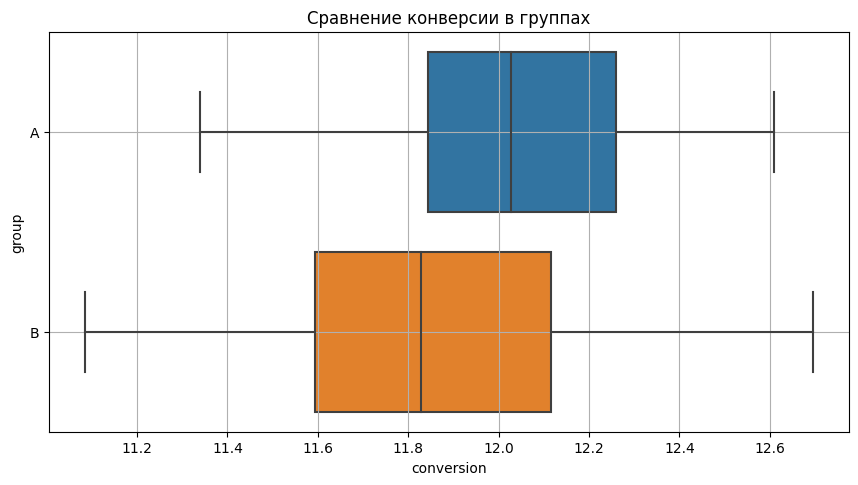

In [134]:
# расчитам конверсию и средний чек для каждой из групп

def get_conversion(row):
    return row['purchase'] / row['users_count'] * 100

def get_average_receipt(row):
    return row['price'] / row['users_count']

daily_data = data.groupby(['date','group']).agg({
    'user_id': 'count',
    'purchase': 'sum',
    'price': 'sum',
}).reset_index().rename(columns={'user_id': 'users_count'})

daily_data['conversion'] = daily_data.apply(lambda x: get_conversion(x), axis=1)
daily_data['average_receipt'] = daily_data.apply(lambda x: get_average_receipt(x), axis=1)

# вычисляем медианное и среднее значение конверсии
conversion_piv = daily_data.groupby('group')['conversion'].agg(
    ['mean', 'median']
)
print('===== Конверсия =====')
display(conversion_piv)

# вычисляем медианное и среднее значение
average_receipt_piv = daily_data.groupby('group')['average_receipt'].agg(
    ['mean', 'median']
)
print('===== Средний чек =====')
display(average_receipt_piv)

# визуализируем конверсию
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1, 1, 1, 1])
sns.boxplot(data=daily_data, x='conversion', y='group', ax=ax)
ax.set_title('Сравнение конверсии в группах')
ax.grid(True)


Выводы:
* по конверсии группа А выглядет предпочтительней, поскольку медианное значение конверсии выше и разброс меньше, чем у группы B.
* по среднему чеку группа B выглядит предпочтительнее, поскольку и среднее, и медианное значение среднего чека выше чем в группе А

price,10000,60000,100000,150000,200000
group,,,,,
A,5182,5271,1832,3478,1724
B,5201,1730,5227,3438,1694


Text(0.5, 36.72222222222221, 'Цена тура')

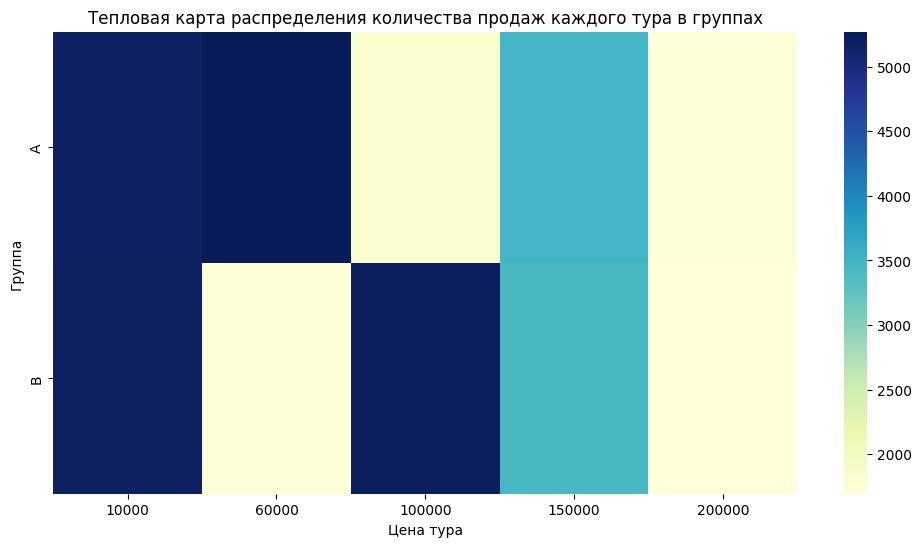

In [135]:
# построим сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура
purchased_data = data[data['purchase'] == 1]
pivot = purchased_data.pivot_table(
    'purchase',
    index='group',
    columns='price',
    aggfunc='count'
)
display(pivot)

fig, axes = plt.subplots(figsize=(12, 6))
heatmap = sns.heatmap(data=pivot, ax=axes, cmap='YlGnBu')
heatmap.set_title('Тепловая карта распределения количества продаж каждого тура в группах')
heatmap.set_ylabel('Группа')
heatmap.set_xlabel('Цена тура')


Выводы:
* покупательская способность участников группы А выше для тура в Турцию (60 000 руб.)
* покупательская способность участников группы В выше для тура в Таиланд (100 000 руб.)
* для остальных туров покупательская способность участников обеих групп явно не отличается

## 3. Проверка стабилизации метрик в A/B-тесте

In [136]:
# будем работать с таблицей с ежедневными данными, построенной на предыдущем шаге
daily_data.head()

,date,group,users_count,purchase,price,conversion,average_receipt
0,2021-01-02,A,2854,359,29410000,12.578837,10304.835319
1,2021-01-02,B,2861,345,29660000,12.058721,10367.004544
2,2021-01-03,A,6596,748,62000000,11.340206,9399.636143
3,2021-01-03,B,6619,754,65960000,11.391449,9965.251549
4,2021-01-04,A,6566,799,64250000,12.168748,9785.257387


In [137]:
# добавим кумулятивные показатели в таблицу с ежедневными данными

# вычисляем кумулятивную сумму количества посетителей
daily_data['cum_users_count'] = daily_data.groupby(['group'])['users_count'].cumsum()

# вычисляем кумулятивную сумму количества совершённых покупок
daily_data['cum_purchase'] = daily_data.groupby(['group'])['purchase'].cumsum()

# вычисляем кумулятивную сумму покупок
daily_data['cum_price'] = daily_data.groupby(['group'])['price'].cumsum()

# вычисляем кумулятивную конверсию
daily_data['cum_conversion'] = daily_data['cum_purchase' / daily_data['cum_users_count'] * 100

# вычисляем кумулятивный средний чек
daily_data['cum_average_receipt'] = daily_data['cum_price'] / daily_data['cum_users_count']

display(daily_data.head())

,date,group,users_count,purchase,price,conversion,average_receipt,cum_users_count,cum_purchase,cum_price,cum_conversion,cum_average_receipt
0,2021-01-02,A,2854,359,29410000,12.578837,10304.835319,2854,359,29410000,12.578837,10304.835319
1,2021-01-02,B,2861,345,29660000,12.058721,10367.004544,2861,345,29660000,12.058721,10367.004544
2,2021-01-03,A,6596,748,62000000,11.340206,9399.636143,9450,1107,91410000,11.714286,9673.015873
3,2021-01-03,B,6619,754,65960000,11.391449,9965.251549,9480,1099,95620000,11.592827,10086.497890
4,2021-01-04,A,6566,799,64250000,12.168748,9785.257387,16016,1906,155660000,11.900599,9719.030969


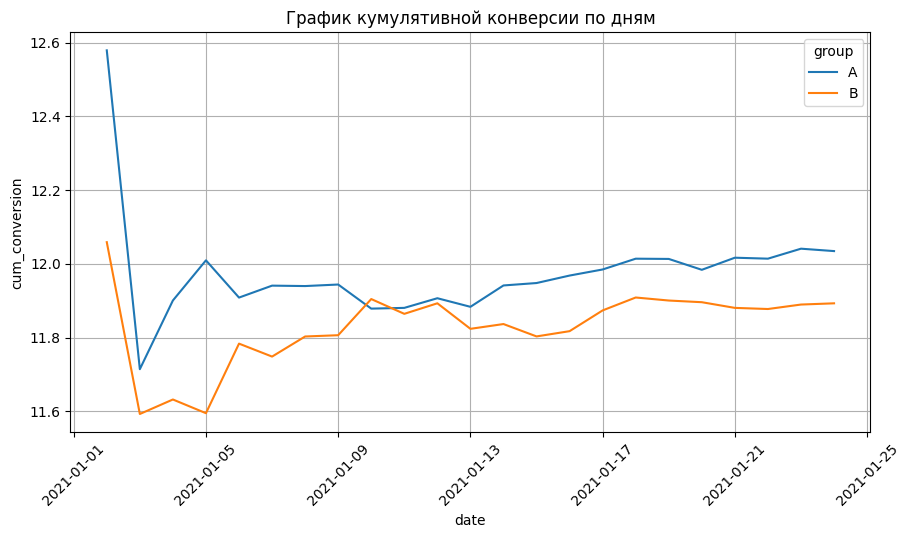

In [138]:
# создаём график кумулятивной конверсии по дням
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1, 1, 1, 1])
sns.lineplot(x='date', y='cum_conversion', data=daily_data, hue='group', ax=ax)
ax.set_title('График кумулятивной конверсии по дням')
ax.xaxis.set_tick_params(rotation = 45)
ax.grid(True)

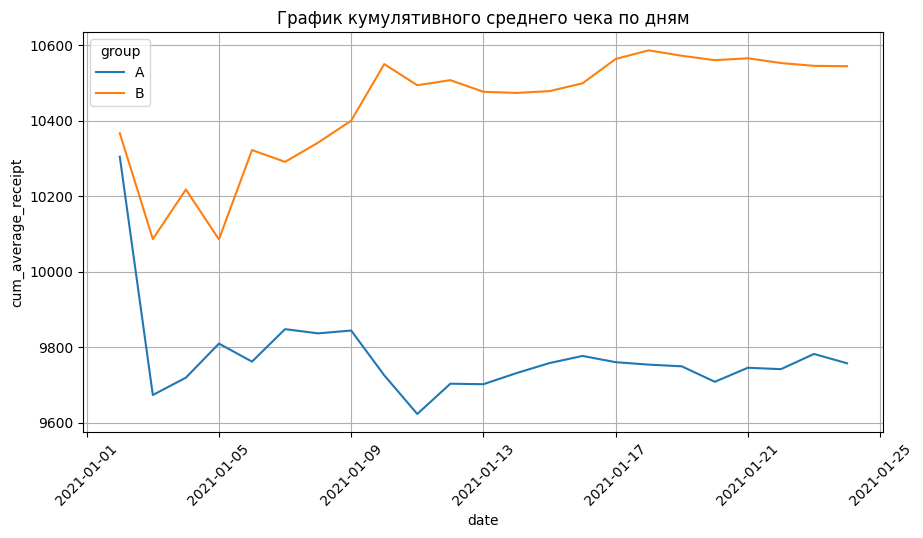

In [139]:
# создаём график кумулятивного среднего чека по дням
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1, 1, 1, 1])
sns.lineplot(x='date', y='cum_average_receipt', data=daily_data, hue='group', ax=ax)
ax.set_title('График кумулятивного среднего чека по дням')
ax.xaxis.set_tick_params(rotation = 45)
ax.grid(True)

Выводы:
* по обоим графикам можно сказать, что А/B тест завершен: после 2021-01-13 резкие скачки как конверсии, так и среднего чека прекратились, и кривыи стабилизировались
* группа А показывает лучшие результаты по конверсии, а группа В показывает лучшие результаты по среднему чеку

## 4. Статистические тесты для анализа результатов A/B-теста

In [153]:
alpha = 0.05

# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p, H0, H1):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
        print(H1)
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))
        print(H0)



**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим данные по конверсии и среднему чеку на нормальность:

* `Нулевая гипотеза` ($H_0$): распределение данных является нормальным.
* `Альтернативная гипотеза` ($H_1$): распределение данных отлично от нормального.

In [149]:
conversion_a = daily_data.loc[daily_data['group'] == 'A', 'conversion']
conversion_b = daily_data.loc[daily_data['group'] == 'B', 'conversion']
average_receipt_a = daily_data.loc[daily_data['group'] == 'A', 'average_receipt']
average_receipt_b = daily_data.loc[daily_data['group'] == 'B', 'average_receipt']

# проводим тест Шапиро-Уилка

print('Для конверсии в группе A:')
result = stats.shapiro(conversion_a)
decision_normality(result[1])

print('\nДля конверсии в группе B:')
result = stats.shapiro(conversion_b)
decision_normality(result[1])

print('\nДля среднего чека в группе A:')
result = stats.shapiro(average_receipt_a)
decision_normality(result[1])

print('\nДля среднего чека в группе B:')
result = stats.shapiro(average_receipt_b)
decision_normality(result[1])

Для конверсии в группе A:
p-value = 0.294
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

Для конверсии в группе B:
p-value = 0.913
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

Для среднего чека в группе A:
p-value = 0.219
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

Для среднего чека в группе B:
p-value = 0.200
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака `conversion` / `averate_receipt`? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Да.

Чтобы проверить нашу гипотезу, можно использовать двухвыборочный t-критерий.

**Проведём тест**

In [156]:
# проводим тест Левена на равенство дисперсий
print('Тест на равенство дисперсий')
_, p = stats.levene(conversion_a, conversion_b)
print('p-value = {:.3f}'.format(p))
if p < alpha:
    print('Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.')
else:
    print('Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.')

# проводим тест
H0 = 'Нулевая гипотеза: конверсия в группах А и В не отличается.'
H1 = 'Альтернативная гипотеза: конверсия в группах А и В отличается.'
print("\n=== t-критерий для сравнения средних значений конверсий в группах: ===")
_, p = stats.ttest_ind(conversion_a, conversion_b, equal_var=True)
decision_hypothesis(p, H0, H1)


Тест на равенство дисперсий
p-value = 0.787
Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.

=== t-критерий для сравнения средних значений конверсий в группах: ===
p-value = 0.223
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.
Нулевая гипотеза: конверсия в группах А и В не отличается.


In [159]:
# проводим тест Левена на равенство дисперсий
print('Тест на равенство дисперсий')
_, p = stats.levene(average_receipt_a, average_receipt_b)
print('p-value = {:.3f}'.format(p))
if p < alpha:
    print('Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.')
else:
    print('Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.')

# проводим тест
H0 = 'Нулевая гипотеза: средний чек в группах А и В не отличается.'
H1 = 'Альтернативная гипотеза: средний чек в группах А и В отличается.'
print("\n=== t-критерий для сравнения средних значений конверсий в группах: ===")
_, p = stats.ttest_ind(average_receipt_a, average_receipt_b, equal_var=True)
decision_hypothesis(p, H0, H1)

Тест на равенство дисперсий
p-value = 0.426
Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.

=== t-критерий для сравнения средних значений конверсий в группах: ===
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.
Альтернативная гипотеза: средний чек в группах А и В отличается.


In [160]:
def proportions_conf_interval(n, x_p, gamma=0.95):
    alpha = 1 - gamma
    z_crit = -stats.norm.ppf(alpha / 2)
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5
    lower_bound = x_p - eps
    higher_bound = x_p + eps
    return round(lower_bound * 100, 2), round(higher_bound * 100, 2)

a_data = data[data['group'] == 'A']
b_data = data[data['group'] == 'B']

conf_interval_a = proportions_conf_interval(
    n=a_data['user_id'].count(),
    x_p=a_data['purchase'].mean()
)

conf_interval_b = proportions_conf_interval(
    n=b_data['user_id'].count(),
    x_p=b_data['purchase'].mean()
)

print(f'Доверительный интервал для конверсии группы А: {conf_interval_a}')
print(f'Доверительный интервал для конверсии группы B: {conf_interval_b}')

Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)


In [162]:
def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -stats.norm.ppf(alpha/2)
    eps = z_crit * (xp[0] * (1 - xp[0]) / n[0] + xp[1] * (1 - xp[1]) / n[1]) ** 0.5
    lower_bound = diff - eps
    higher_bound = diff + eps
    return round(lower_bound * 100, 2), round(higher_bound * 100, 2)

# размеры выборок групп А и B
n = [a_data['user_id'].count(), b_data['user_id'].count()]

# выборочная пропорция групп A и B
xp = [a_data['purchase'].mean(), b_data['purchase'].mean()]

# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)

print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))


Доверительный интервал для разности конверсий: (-0.38, 0.09)


In [166]:
# Определим доверительный интервал для среднего чека

def conf_interval(n, x_mean, x_std, gamma=0.95):
  alpha = 1 - gamma
  k = n - 1
  t_crit = -stats.t.ppf(alpha/2, k)
  eps = t_crit * x_std/(n ** 0.5)
  lower_bound = x_mean - eps
  upper_bound = x_mean + eps
  return round(lower_bound, 2), round(upper_bound, 2)

# Доверительный интервал для группы A
n = a_data['cum_purchase'].max()
x_mean = a_data['average_receipt'].mean()
x_std = a_data['average_receipt'].std()
print('Доверительный интервал для истинного среднего чека группы А:', conf_interval(n, x_mean, x_std))

# Доверительный интервал для группы B
n = b_data['cum_purchase'].max()
x_mean = b_data['average_receipt'].mean()
x_std = b_data['average_receipt'].std()
print('Доверительный интервал для истинного среднего чека группы B:', conf_interval(n, x_mean, x_std))

Доверительный интервал для истинного среднего чека группы А: (9745.48, 9760.99)
Доверительный интервал для истинного среднего чека группы B: (10531.81, 10545.31)


__Выводы__:
* конверсия в группах А и В статистически не отличается:
    * получено подтверждение с помощью t-критерия
    * пересечение доверительных интервалов группы А (11.87, 12.2) и В (11.73, 12.06) на уровне доверия 95%
    * доверительный интервал для разности конверсий (-0.38, 0.09) подтверждает, что не смотря на то, что существует вероятность того, что конверсия в группе B выше, чем в группе A, разница все же не является статистически значимой.
* средний чек в группе В статистически отличается от среднего чека в группе А:
    * получено подтверждение с помощью t-критерия
    * доверительные интервалы группы А (9745.48, 9760.99) и В (10531.81, 10545.31) не пересекаются, что может указывать на значимые различия в среднем чеке между группами А и B на уровне доверия 95%

## 6. Соответствие выводов бизнес-вопросам

Таким образом, если рассматривать эффективность по метрикам конверсии и ежедневного среднего чека, можно сделать следующие выводы:

1. По метрике конверсии: оба варианта дизайна равнозначны, поскольку не обнаружены статистически значимые различия в конверсии между группами А и B.

2. По метрике среднего чека: вариант дизайна страницы B более эффективен, так как приводит к статистически значимо более высокому среднему чеку по сравнению с вариантом дизайна страницы A.

Итак, при прочих равных условиях, можно сделать вывод, что вариант дизайна страницы B является более предпочтительным с точки зрения увеличения среднего чека пользователей.